## COVID-19

Date: 2020, 31 Mar

This notebook serves as an official template for the seminar for the graduate course in Modeling and Simulation of Physical Systems [FEMT16](https://nastava.fesb.unist.hr/nastava/predmeti/11623), taught by professors Dragan Poljak and Ivica Puljak. 

In [1]:
# libs
import numpy as np 
import matplotlib.pyplot as plt 

from SIR.utils import normalize, restore, moving_average
from SIR.plotting import plotData, figsize, latexconfig
from SIR.model import ExponentialModel, LogisticModel
from SIR.SIR import SIRModel

# enable LaTex figure formatting by uncommenting the following line
latexconfig()

In [2]:
# data
confirmed_cases = np.loadtxt('data/dataset.dat')

# train-test split 
ratio = 1.0
train_size = int(ratio * len(confirmed_cases))
test_cases = confirmed_cases[train_size:]
confirmed_cases = confirmed_cases[:train_size]

# normalized data
normalized_confirmed_cases = normalize(confirmed_cases)

# days since first case
x = np.arange(len(confirmed_cases))

### confirmed cases over time fitted using log function

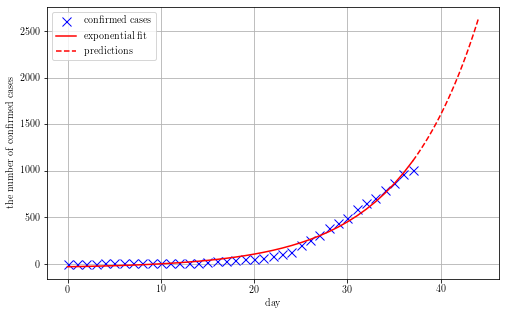

In [4]:
fig, ax = plotData(x, confirmed_cases, False, 1.5)

# log fit on data
exp_model = ExponentialModel()
fitted = exp_model.fit(x, confirmed_cases)
ax.plot(x, fitted, 'r-', label='exponential fit')

# extrapolation 
n_future_days = 7
_x, preds = exp_model.predict(n_future_days)
ax.plot(_x, preds, 'r--', label='predictions')

plt.grid()
plt.legend(loc='best')
plt.show()
fig.savefig('figs/exp-fit.pdf', bbox_inches='tight')

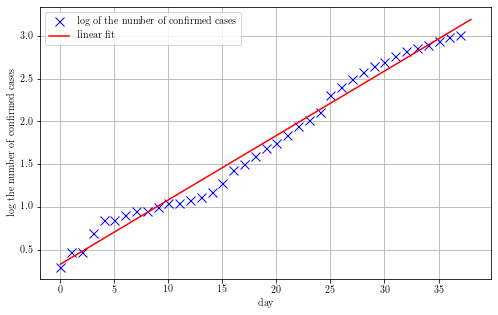

In [5]:
from sklearn.linear_model import LinearRegression

# linear fit in log-view
fig, ax = plotData(x, confirmed_cases, True, 1.5, 1)

linear_confirmed_cases = np.log10(confirmed_cases)
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(x.reshape(-1, 1), linear_confirmed_cases.reshape(-1, 1))
_x = np.linspace(0, len(x), 100)
predict = linear_model.predict(_x.reshape(-1,1))
ax.plot(_x, predict, 'r-', label='linear fit')

plt.grid()
plt.legend(loc='best')
plt.show()
fig.savefig('figs/lin-fit-in-log-view.pdf', bbox_inches='tight')

### confirmed cases over time fitted using logistic function

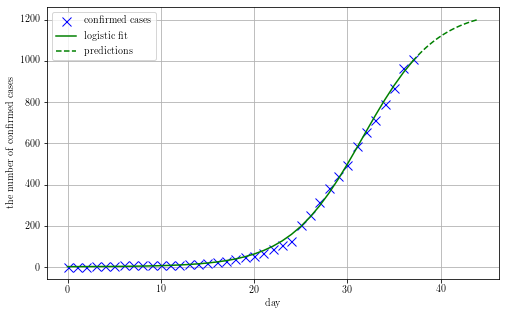

In [6]:
fig, ax, = plotData(x, confirmed_cases, False, 1.5)

# logistic fit on data
logit_model = LogisticModel(normalize=True)
fitted = logit_model.fit(x, confirmed_cases)
ax.plot(x, fitted, 'g-', label='logistic fit')

# extrapolation
_x, preds = logit_model.predict(n_future_days)
ax.plot(_x, preds, 'g--', label='predictions')

plt.grid()
plt.legend(loc='best')
plt.show()
fig.savefig('figs/logit-fit.pdf', bbox_inches='tight')

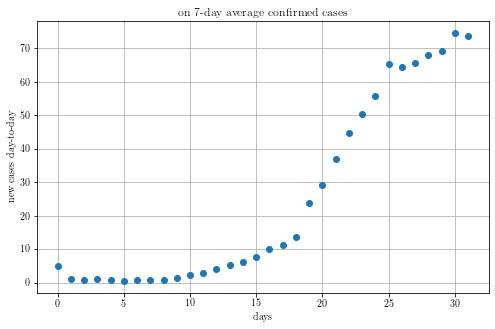

In [7]:
n_avg = 7
confirmed_averaged = moving_average(confirmed_cases, n=n_avg)

new_cases = []
for epoch, csp in enumerate(confirmed_averaged):
    if epoch==0:
        new_cases.append(csp)
    else: 
        new_cases.append(confirmed_averaged[epoch] - confirmed_averaged[epoch-1])
new_cases = np.array(new_cases)

fig = plt.figure(figsize=figsize(1.5,1))
ax = fig.add_subplot(111)
ax.plot(new_cases, 'o')
ax.set_xlabel('days')
ax.set_ylabel('new cases day-to-day')
plt.title(f'on {n_avg}-day average confirmed cases')

plt.grid()
plt.show()
fig.savefig('figs/7-day-avg-new-cases-val_v_time.pdf', bbox_inches='tight')

### new confirmed cases vs total confirmed cases every $n$ days

* log scaled both x and y axes
* focus is change and not actual numbers
* time is implied, the trend is what matters here

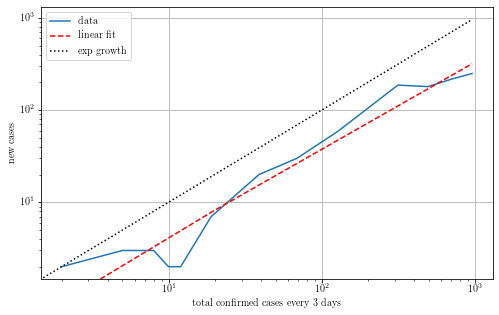

In [8]:
# log scaled: new confirmed cases vs total confirmed cases
iterations, *_ = confirmed_cases.shape
confirmed_cases_periodically = []
epoch = 0
period = 3
while epoch < iterations:
    confirmed_cases_periodically.append(confirmed_cases[epoch])
    epoch += period

confirmed_cases_periodically = np.array(confirmed_cases_periodically)

new_cases = []
for epoch, csp in enumerate(confirmed_cases_periodically):
    if epoch==0:
        new_cases.append(csp)
    else: 
        new_cases.append(confirmed_cases_periodically[epoch] - confirmed_cases_periodically[epoch-1])

new_cases = np.array(new_cases)

fig = plt.figure(figsize=figsize(1.5,1))
ax = fig.add_subplot(111)
ax.loglog(confirmed_cases_periodically, new_cases, '-', label='data')
plt.xlabel(f'total confirmed cases every {period} days')
plt.ylabel(f'new cases')

# fitting it linearly to check if the growth is exponential
_x = np.linspace(0, np.max(confirmed_cases_periodically))
k, b = np.polyfit(np.log(confirmed_cases_periodically), np.log(new_cases), 1)
y = _x**k * np.exp(b)
ax.plot(_x, y, 'r--', label='linear fit')

# exponential growth ground
ax.plot(_x, _x, 'k:', label='exp growth')

plt.grid()
plt.legend()
plt.show()
fig.savefig('figs/new-cases_v_7-day-avg-total-cases.pdf', bbox_inches='tight')

### fitting the data using learning algorithm: Gaussian Processes

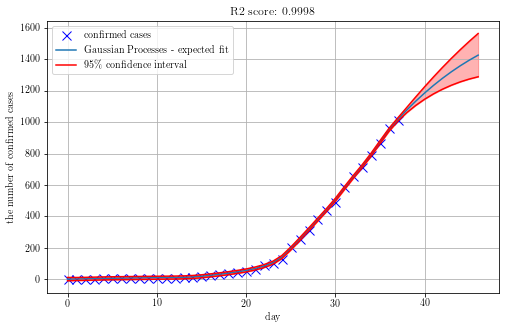

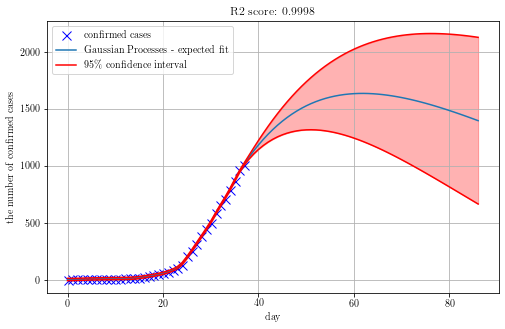

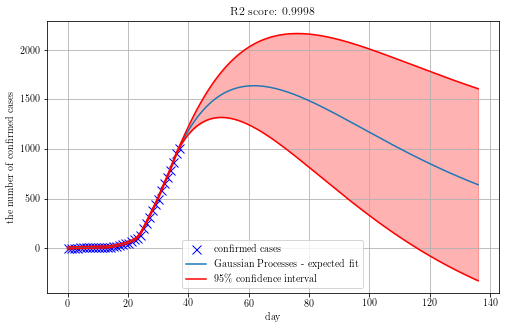

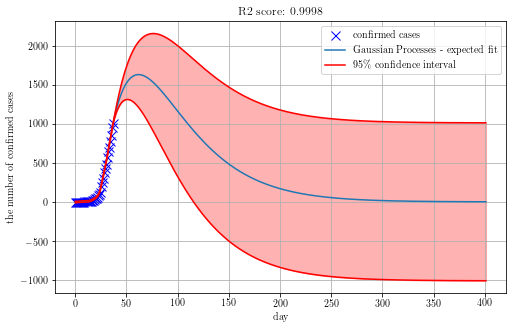

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.metrics import r2_score

# GPs
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x.reshape(-1,1), normalized_confirmed_cases.reshape(-1,1))

# simulated data
n_future_days_list = [10, 50, 100, 365]

for i, n_d in enumerate(n_future_days_list):
    x_pred = np.arange(0, len(x)+n_d-1).reshape(-1,1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    x_pred = x_pred.ravel()
    y_pred, sigma = y_pred.ravel(), sigma.ravel()

    # restore data
    y_pred = restore(y_pred, confirmed_cases)
    sigma = restore(sigma, confirmed_cases)
    y_pred_lower_bound = y_pred - sigma
    y_pred_upper_bound = y_pred + sigma

    fig, ax = plotData(x, confirmed_cases, False, 1.5, 1)
    ax.plot(x_pred, y_pred, label='Gaussian Processes - expected fit')
    ax.plot(x_pred, y_pred_lower_bound, color='red', label='95\% confidence interval')
    ax.plot(x_pred, y_pred_upper_bound, color='red')
    ax.fill_between(x_pred, 
                     y_pred_lower_bound, y_pred_upper_bound, 
                     color='red', alpha='0.3')
    
    ax.plot(np.arange(len(confirmed_cases), len(confirmed_cases)+len(test_cases)), test_cases, 'ko', linestyle='None')
    plt.title(f'R2 score: {np.round(r2_score(confirmed_cases, y_pred[:len(confirmed_cases)]),4)}')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    fig.savefig(f'figs/gp-extrapolation-{n_d}-days.pdf', bbox_inches='tight')

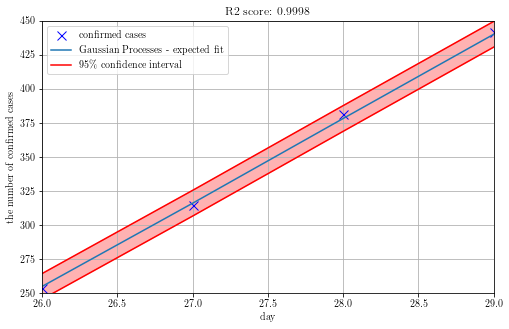

In [10]:
# zoom in a little bit

fig, ax = plotData(x, confirmed_cases, False, 1.5, 1)
ax.plot(x_pred, y_pred, label='Gaussian Processes - expected fit')
ax.plot(x_pred, y_pred_lower_bound, color='red', label='95\% confidence interval')
ax.plot(x_pred, y_pred_upper_bound, color='red')
ax.fill_between(x_pred, 
                 y_pred_lower_bound, y_pred_upper_bound,
                 color='red', alpha='0.3')
plt.title(f'R2 score: {np.round(r2_score(confirmed_cases, y_pred[:len(confirmed_cases)]),4)}')
plt.axis([26, 29, 250, 450])
plt.grid()
plt.legend(loc='best')
plt.show()

fig.savefig('figs/gp-zoom-in.pdf', bbox_inches='tight')

### SIR model

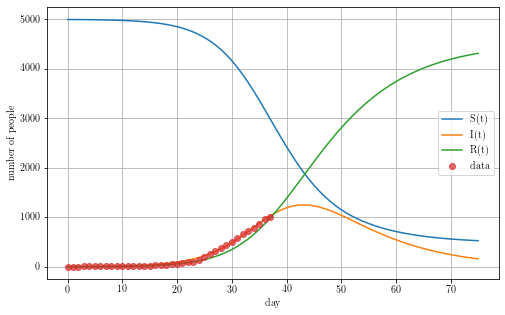

In [11]:
S0, I0, R0 = 5000, 2, 0
initial_conditions = [S0, I0, R0]
n_future_days = len(confirmed_cases) * 2

sir_model = SIRModel()
beta, gamma = sir_model.fit(confirmed_cases, initial_conditions)
sol = sir_model.predict(n_future_days)

fig = plt.figure(figsize=figsize(1.5, 1))
ax = fig.add_subplot(111)
ax.plot(sol.y[0], label='S(t)')
ax.plot(sol.y[1], label='I(t)')
ax.plot(sol.y[2], label='R(t)')
ax.plot(confirmed_cases, linestyle='None', marker='o', alpha=0.7, label='data')
ax.plot(np.arange(len(confirmed_cases), len(confirmed_cases)+len(test_cases)), test_cases, 'ko', linestyle='None')

plt.xlabel('day')
plt.ylabel('number of people')

plt.grid()
plt.legend(loc='best')
plt.show()
fig.savefig('figs/toy-sir-model-RK4-solver.pdf', bbox_inches='tight')

### SUQC model

### References

* Data source:

    [1] [koronvirus.hr](https://www.koronavirus.hr/) - official site of the Government of the Republic of Croatia for timely and accurate information on COVID-19

---

* References for simple log, logit and linear epidemics modeling:

    [1] [Exponential growth and epidemics](https://www.youtube.com/watch?v=Kas0tIxDvrg) - 3blue1brown YouTube video

---

*  References for modeling of Covid-19 by observing logplot of new cases v. smoothed confirmed cases:

    [1] [How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc) - minutephysics YouTube video

---

* References for Gaussian processes:
    
    [1] [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/) - distil.pub blog post based on [2]

    [2] [Gaussian Processes in Machine Learning](https://link.springer.com/chapter/10.1007%2F978-3-540-28650-9_4) - 2003. Carl Edward Rasmussen's primer on Gaussian Processes

    [3] [Gaussian Processes - A Replacement for Supervised Neural Networks?](https://scholar.google.com/scholar?q=MacKay%2C%20D.J.C.%3A%20Gaussian%20processes%20%E2%80%94%20a%20replacement%20for%20supervised%20neural%20networks%3F.%20Tutorial%20lecture%20notes%20for%20NIPS%201997%20%281997%29) - 1997. D. MacKay's paper
    
    [4] hands-on blog posts: https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

---

* References for SIR:
    
    [1] [Introduction to SEIR Models - Swiss TPH](http://indico.ictp.it/event/7960/session/3/#20170508) - 2017. Nakul Chitnis' presentation on SEIR Model
    
    [2] [Mathematical Theory of Epidemics I](https://link.springer.com/article/10.1007/BF02464423) - 1927. W. O. Kermack & A. G. McKendrick - I. 
    
    [3] [Mathematical Theory of Epidemics II - The Problem of Endemicity](https://www.sciencedirect.com/science/article/abs/pii/S0092824005800412) - 1927. W. O. Kermack & A. G. McKendrick - II. 
    
    [4] [Mathematical Theory of Epidemics III - Further Studies of the Problem of Endemicity](https://www.sciencedirect.com/science/article/abs/pii/S0092824005800424) - 1927. W. O. Kermack & A. G. McKendrick - III.
    
    [5] [Measurement and Modeling - Infectious Disease Modeling](https://www.sciencedirect.com/science/article/pii/B9780128036785002290?via%3Dihub) - 2016. Mirjam Kretzschmar's Measurement and Modeling: Infectious Disease Modeling chapter in International Encyclopedia of Public Health
     
    [6] [Modeling the epidemic dynamics and control of COVID-19 outbreak in China](https://link.springer.com/article/10.1007%2Fs40484-020-0199-0) - 2020. paper by Shilei Zhao & Hua Chen
    
    [7] [Neural Network Aided Quarantine Control Model Estimation of COVID Spread in Wuhan, China](https://arxiv.org/abs/2003.09403v1) - 2020. paper by Raj Dandekar & George Barbastathis. Here the [Universal Differential Equations](https://arxiv.org/abs/2001.04385) are used in order to estimate the effects of quarantine and understand their effect on the spread of COVID-19.